#### Instead of using the previous values as features, use the hour, day, day of the week, week of the year information, as well as the periodicity information, along with checking whether the day is a holiday using the holiday module as features to predict the current value using RNN. This can be done by creating a new dataframe with these featuresand labels.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import copy
import datetime
import holidays

In [3]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
df=pd.read_csv('/home/agcl/Downloads/rnn_dataset.csv')

In [5]:
df

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0
...,...,...
143201,2018-01-01 20:00:00,8401.0
143202,2018-01-01 21:00:00,8373.0
143203,2018-01-01 22:00:00,8238.0
143204,2018-01-01 23:00:00,7958.0


<AxesSubplot:xlabel='Datetime'>

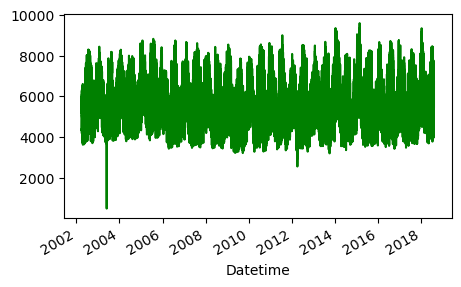

In [6]:
# Convert the 'Datetime' column to a datetime data type
df['Datetime'] = pd.to_datetime(df['Datetime'], infer_datetime_format=True)

# Sort the DataFrame by the 'Datetime' column in ascending order
df = df.sort_values('Datetime')

# Set the 'Datetime' column as the index of the DataFrame
df.set_index('Datetime', inplace=True)

# Plot the time-series data of the 'PJMW_MW' column
df['PJMW_MW'].plot(c='g', figsize=(5, 3))

In [7]:
df = df.rename(columns={'PJMW_MW': 'values'})

In [8]:
df

,values
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0
...,...
2018-08-02 20:00:00,6545.0
2018-08-02 21:00:00,6496.0
2018-08-02 22:00:00,6325.0


In [9]:
'''Here, I converted the date and time details to datetime object and various features are created using the
details of hour,week of year,etc.'''
df['hour']=df.index.hour
#df['date']=df.index.date
#df['year']=df.index.year
df['month']=df.index.month
#df['quarter']=df.index.quarter
df['day']=df.index.day
df['day_of_week']=df.index.day_name()
#df['second']=df.index.second
df['week_of_year']=df.index.week

/tmp/ipykernel_35935/2176535447.py:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week_of_year']=df.index.week


In [10]:
df

,values,hour,month,day,day_of_week,week_of_year
Datetime,,,,,,
2002-04-01 01:00:00,4374.0,1,4,1,Monday,14
2002-04-01 02:00:00,4306.0,2,4,1,Monday,14
2002-04-01 03:00:00,4322.0,3,4,1,Monday,14
2002-04-01 04:00:00,4359.0,4,4,1,Monday,14
2002-04-01 05:00:00,4436.0,5,4,1,Monday,14
...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,20,8,2,Thursday,31
2018-08-02 21:00:00,6496.0,21,8,2,Thursday,31
2018-08-02 22:00:00,6325.0,22,8,2,Thursday,31


In [11]:
'''Considering saturday and sunday as weekend holidays'''
#df['is_weekend']=df['day_of_week'].isin(['Saturday','Sunday'])

'Considering saturday and sunday as weekend holidays'

In [12]:
df

,values,hour,month,day,day_of_week,week_of_year
Datetime,,,,,,
2002-04-01 01:00:00,4374.0,1,4,1,Monday,14
2002-04-01 02:00:00,4306.0,2,4,1,Monday,14
2002-04-01 03:00:00,4322.0,3,4,1,Monday,14
2002-04-01 04:00:00,4359.0,4,4,1,Monday,14
2002-04-01 05:00:00,4436.0,5,4,1,Monday,14
...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,20,8,2,Thursday,31
2018-08-02 21:00:00,6496.0,21,8,2,Thursday,31
2018-08-02 22:00:00,6325.0,22,8,2,Thursday,31


In [13]:
'''Using the holiday module in Python, all the holidays in India between 2003 and 2018 was found out'''
country='India'
years_range=list(range(2003,2018))
holidays_list=[]
for date in holidays.CountryHoliday(country,years=years_range).items():
    holidays_list.append(str(date[0]))
    

In [14]:
len(holidays_list)

271

In [15]:
df['is_holiday']=df.index.isin(holidays_list)

In [16]:
df

,values,hour,month,day,day_of_week,week_of_year,is_holiday
Datetime,,,,,,,
2002-04-01 01:00:00,4374.0,1,4,1,Monday,14,False
2002-04-01 02:00:00,4306.0,2,4,1,Monday,14,False
2002-04-01 03:00:00,4322.0,3,4,1,Monday,14,False
2002-04-01 04:00:00,4359.0,4,4,1,Monday,14,False
2002-04-01 05:00:00,4436.0,5,4,1,Monday,14,False
...,...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,20,8,2,Thursday,31,False
2018-08-02 21:00:00,6496.0,21,8,2,Thursday,31,False
2018-08-02 22:00:00,6325.0,22,8,2,Thursday,31,False


In [17]:
'''This function is used to extract periodicity of the various features of the data'''
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs)


In [18]:
df_features=pd.DataFrame()
df = generate_cyclical_features(df, 'hour', 24, 0)
df = generate_cyclical_features(df, 'month', 12, 1)
df = generate_cyclical_features(df, 'week_of_year', 52, 0)

df

,values,hour,month,day,day_of_week,week_of_year,is_holiday,sin_hour,cos_hour,sin_month,cos_month,sin_week_of_year,cos_week_of_year
Datetime,,,,,,,,,,,,,
2002-04-01 01:00:00,4374.0,1,4,1,Monday,14,False,0.258819,0.965926,1.0,6.123234e-17,0.992709,-0.120537
2002-04-01 02:00:00,4306.0,2,4,1,Monday,14,False,0.500000,0.866025,1.0,6.123234e-17,0.992709,-0.120537
2002-04-01 03:00:00,4322.0,3,4,1,Monday,14,False,0.707107,0.707107,1.0,6.123234e-17,0.992709,-0.120537
2002-04-01 04:00:00,4359.0,4,4,1,Monday,14,False,0.866025,0.500000,1.0,6.123234e-17,0.992709,-0.120537
2002-04-01 05:00:00,4436.0,5,4,1,Monday,14,False,0.965926,0.258819,1.0,6.123234e-17,0.992709,-0.120537
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,20,8,2,Thursday,31,False,-0.866025,0.500000,-0.5,-8.660254e-01,-0.568065,-0.822984
2018-08-02 21:00:00,6496.0,21,8,2,Thursday,31,False,-0.707107,0.707107,-0.5,-8.660254e-01,-0.568065,-0.822984
2018-08-02 22:00:00,6325.0,22,8,2,Thursday,31,False,-0.500000,0.866025,-0.5,-8.660254e-01,-0.568065,-0.822984


In [682]:
'''Here,one-hot encoding is performed for the categorical features'''
a=pd.get_dummies(df['day_of_week'])
df=pd.concat([df, a], axis=1)
df = df.drop('day_of_week', axis=1)
a=pd.get_dummies(df['hour'])
df=pd.concat([df, a], axis=1)
df = df.drop('hour', axis=1)
# a=pd.get_dummies(df['is_weekend'])
# df=pd.concat([df, a], axis=1)
# df = df.drop('is_weekend', axis=1)
a=pd.get_dummies(df['is_holiday'])
df=pd.concat([df, a], axis=1)
df = df.drop('is_holiday', axis=1)
a=pd.get_dummies(df['week_of_year'])
df=pd.concat([df, a], axis=1)
df = df.drop('week_of_year', axis=1)
a=pd.get_dummies(df['month'])
df=pd.concat([df, a], axis=1)
df = df.drop('month', axis=1)
a=pd.get_dummies(df['day'])
df=pd.concat([df, a], axis=1)
df = df.drop('day', axis=1)

In [683]:
df

,values,sin_hour,cos_hour,sin_month,cos_month,sin_week_of_year,cos_week_of_year,Friday,Monday,Saturday,...,22,23,24,25,26,27,28,29,30,31
Datetime,,,,,,,,,,,,,,,,,,,,,
2002-04-01 01:00:00,4374.0,0.258819,0.965926,1.0,6.123234e-17,0.992709,-0.120537,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2002-04-01 02:00:00,4306.0,0.500000,0.866025,1.0,6.123234e-17,0.992709,-0.120537,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2002-04-01 03:00:00,4322.0,0.707107,0.707107,1.0,6.123234e-17,0.992709,-0.120537,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2002-04-01 04:00:00,4359.0,0.866025,0.500000,1.0,6.123234e-17,0.992709,-0.120537,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2002-04-01 05:00:00,4436.0,0.965926,0.258819,1.0,6.123234e-17,0.992709,-0.120537,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,-0.866025,0.500000,-0.5,-8.660254e-01,-0.568065,-0.822984,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-08-02 21:00:00,6496.0,-0.707107,0.707107,-0.5,-8.660254e-01,-0.568065,-0.822984,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-08-02 22:00:00,6325.0,-0.500000,0.866025,-0.5,-8.660254e-01,-0.568065,-0.822984,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [684]:
print(df.shape)

(143206, 136)


In [685]:
data=np.array(df)

In [686]:
values=df['values']
values

Datetime
2002-04-01 01:00:00    4374.0
2002-04-01 02:00:00    4306.0
2002-04-01 03:00:00    4322.0
2002-04-01 04:00:00    4359.0
2002-04-01 05:00:00    4436.0
                        ...  
2018-08-02 20:00:00    6545.0
2018-08-02 21:00:00    6496.0
2018-08-02 22:00:00    6325.0
2018-08-02 23:00:00    5892.0
2018-08-03 00:00:00    5489.0
Name: values, Length: 143206, dtype: float64

In [687]:
values=np.array(values)

In [688]:
m=values.shape[0]
values=values.reshape(m,1)
values.shape

(143206, 1)

In [689]:
data_final = df.drop('values', axis=1)
data_final=np.array(data_final)
print(data_final.shape)

(143206, 135)


In [690]:
X_train,x_test,Y_train,y_test=train_test_split(data_final,values,test_size=0.15,shuffle=False)
x_train,x_val,y_train,y_val=train_test_split(X_train,Y_train,test_size=0.15/0.85,shuffle=False)

In [691]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)
print(x_train)

(100244, 135)
(21481, 135)
(21481, 135)
(100244, 1)
(21481, 1)
(21481, 1)
[[ 2.58819045e-01  9.65925826e-01  1.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.00000000e-01  8.66025404e-01  1.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.07106781e-01  7.07106781e-01  1.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-1.00000000e+00 -1.83697020e-16 -8.66025404e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-9.65925826e-01  2.58819045e-01 -8.66025404e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-8.66025404e-01  5.00000000e-01 -8.66025404e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [692]:
'''Normalising data'''
scaler=StandardScaler()
x_train_norm=scaler.fit_transform(x_train)
x_test_norm=scaler.transform(x_test)
x_val_norm=scaler.transform(x_val)
y_train_norm=scaler.fit_transform(y_train)
y_test_norm=scaler.transform(y_test)
y_val_norm=scaler.transform(y_val)

In [693]:
print(x_train_norm.shape)
print(x_test_norm.shape)
print(x_val_norm.shape)
print(y_train_norm.shape)
print(y_test_norm.shape)
print(y_val_norm.shape)
print(x_train_norm)

(100244, 135)
(21481, 135)
(21481, 135)
(100244, 1)
(21481, 1)
(21481, 1)
[[ 3.66185836e-01  1.36640404e+00  1.40398552e+00 ... -1.78488878e-01
  -1.76335207e-01 -1.39702928e-01]
 [ 7.07252136e-01  1.22511725e+00  1.40398552e+00 ... -1.78488878e-01
  -1.76335207e-01 -1.39702928e-01]
 [ 1.00013241e+00  1.00036243e+00  1.40398552e+00 ... -1.78488878e-01
  -1.76335207e-01 -1.39702928e-01]
 ...
 [-1.41397444e+00  3.18151740e-04 -1.23986982e+00 ... -1.78488878e-01
  -1.76335207e-01 -1.39702928e-01]
 [-1.36578841e+00  3.66359762e-01 -1.23986982e+00 ... -1.78488878e-01
  -1.76335207e-01 -1.39702928e-01]
 [-1.22451412e+00  7.07456241e-01 -1.23986982e+00 ... -1.78488878e-01
  -1.76335207e-01 -1.39702928e-01]]


In [694]:
'''Initializing tensors'''
x_train_norm=torch.tensor(x_train_norm,dtype=torch.float)
x_test_norm=torch.tensor(x_test_norm,dtype=torch.float)
x_val_norm=torch.tensor(x_val_norm,dtype=torch.float)
y_train_norm=torch.tensor(y_train_norm,dtype=torch.float)
y_test_norm=torch.tensor(y_test_norm,dtype=torch.float)
y_val_norm=torch.tensor(y_val_norm,dtype=torch.float)
print(type(x_train_norm))

<class 'torch.Tensor'>


In [695]:
class RNN(nn.Module):
    '''This class defines a simple recurrent neural network model(vanilla/elman RNN) which is used here for the 
    prediction of above given univariate time-series data.
    input_dim: dimensionality of input tensor which is the size of the input vector at each time step(here,100)
    hidden_dim: dimensionality of the hidden state tensor which is the size of the hidden vector passed from one
    timestep to the next(ht-1)
    layer_dim: the number of RNN layers in the network.A layer contains a set of recurent cells that process the 
    input and hidden states to generate the outputs and new hidden states.
    '''
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fully_connected = nn.Linear(hidden_dim, output_dim)

        
    '''forward propagation'''
    def forward(self,x):
        '''takes tensor x as input and computes the forward propagation'''
        h0=torch.zeros(self.layer_dim,x.size(0),self.hidden_dim,device=x.device,requires_grad=True,dtype=torch.float)
        out,h_n=self.rnn(x,h0.detach())
        out=out[:,-1,:]
        out=self.fully_connected(out)
        return out
        
'''detach() is called to avoid the backprop to pass through it.out,ho are the 2 outputs obtained when forward 
propagation is called on rnn.
The dimension of out is (batch-size,sequence_length(input_dim),hidden_dim), which
basically contains the output at each timestep of the sequence.
The dimension of h_n is (layer-dim,batch_size,hidden_dim),which conains the final hidden state of rnn. This can 
be used as an initial state for another rnn instance to continue the sequence.
Note that the dimension of x is in the form (batch_size,input_dim) or (m,n)''' 
        
    

'detach() is called to avoid the backprop to pass through it.out,ho are the 2 outputs obtained when forward \npropagation is called on rnn.\nThe dimension of out is (batch-size,sequence_length(input_dim),hidden_dim), which\nbasically contains the output at each timestep of the sequence.\nThe dimension of h_n is (layer-dim,batch_size,hidden_dim),which conains the final hidden state of rnn. This can \nbe used as an initial state for another rnn instance to continue the sequence.\nNote that the dimension of x is in the form (batch_size,input_dim) or (m,n)'

In [696]:
def dataloader(x,y,batch_size):
    '''Assigning data to dataloader'''
    combined=TensorDataset(x,y)
    loader = DataLoader(combined, batch_size=batch_size, shuffle=False, drop_last=True)
    return loader

In [697]:
def training(model,learning_rate,epochs,weight_decay,batch_size,train_loader,val_loader):
    '''This function can be used to train the model and evaluate the performance of the model by finding the 
    train loss and validation losses. Here, Mean squared error function and r2-score is used as the
    evaluation criteria.'''
    
    criterion=nn.MSELoss()
    optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
    training_losses=[]
    validation_losses=[]
    for epoch in range(1,epochs+1):
        batch_losses=[]
        batch_r2=[]
        for x_batch,y_batch in train_loader:
            x_batch=x_batch.view(batch_size,-1,input_dim)
            '''here 1 is input size which is the no of features or dimensions in each time step of the input 
            sequence.Here,is is 1(univariate problem).So ,we have to convert the input to 3d Tensor as well, 
            since the h matrices will be 3-dimensional and there will be mismatch.Thats why a shape change is 
            given to the input data with -1. When we are giving a 1 dimension in the above tensor, it explicitly 
            sets the second dimension to1, while x.view(a,-1,b) automatically determines the size of the second 
            dimension based on the other specified dimensions and the total number of elements in the tensor.'''
            x_batch=x_batch.to(device)
            y_batch=y_batch.to(device)
            model.train()
            yhat_batch=model(x_batch)
            loss=criterion(y_batch,yhat_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
            
        train_loss=np.mean(batch_losses)
        training_losses.append(train_loss)
        
        with torch.no_grad():
            batch_val_losses=[]
            batch_val_r2=[]
            for x_val,y_val in val_loader:
                x_val=x_val.view(batch_size,-1,input_dim)
                x_val=x_val.to(device)
                y_val=y_val.to(device)
                model.eval()
                yhat_val=model(x_val)
                val_loss=criterion(y_val,yhat_val)
                
                batch_val_losses.append(val_loss.item())
                
            validation_loss=np.mean(batch_val_losses)
            validation_losses.append(validation_loss)
            
        if (epoch <= epochs) | (epoch % 50 == 0):
            print(f"[{epoch}/{epochs}] Training loss: {train_loss:.4f}\t Validation loss: {validation_loss:.4f}")
            
    
    return training_losses,validation_losses
    

In [698]:
def plot_loss(train_loss,val_loss):
    plt.style.use('ggplot')
    plt.figure(figsize=(5,5))
    plt.plot(train_loss,label='Training Loss')
    plt.plot(val_loss,label='Validation loss')
    plt.legend()
    plt.title('Losses')
    plt.show()
    plt.close()
        

[1/10] Training loss: 0.4474	 Validation loss: 0.4951
[2/10] Training loss: 0.3466	 Validation loss: 0.4199
[3/10] Training loss: 0.3111	 Validation loss: 0.4122
[4/10] Training loss: 0.2952	 Validation loss: 0.4021
[5/10] Training loss: 0.2875	 Validation loss: 0.4016
[6/10] Training loss: 0.2815	 Validation loss: 0.4038
[7/10] Training loss: 0.2765	 Validation loss: 0.4009
[8/10] Training loss: 0.2716	 Validation loss: 0.4018
[9/10] Training loss: 0.2675	 Validation loss: 0.4029
[10/10] Training loss: 0.2641	 Validation loss: 0.4049


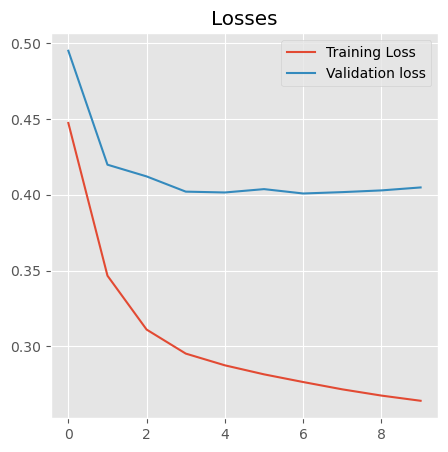

In [699]:
'''training the model'''
'''This model is flexible to change the number of hidden layers and number of neurons in the hidden layers also.
There is a fully connected layer and the number of neurons is given as one since we need a single prediction.
Based on the requirements, it can also be changed as well.
The data loader function can be used to'''
input_dim=x_train.shape[1]
output_dim=1
hidden_dim=64
layer_dim=1
batch_size=64
epochs=10
learning_rate=1e-3
weight_decay=1e-5
model=RNN(input_dim,hidden_dim,layer_dim,output_dim)
model.cuda() # when we are using the gpu through cuda,all the data,parameters and the model created should be 
#assigned to cuda by using this function call.
train_loader=dataloader(x_train_norm,y_train_norm,batch_size)
val_loader=dataloader(x_val_norm,y_val_norm,batch_size)
train_loss,validation_loss = training(model,learning_rate,epochs,weight_decay,
                                                batch_size,train_loader,val_loader)
plot_loss(train_loss,validation_loss)

In [700]:
x_test_norm.shape

torch.Size([21481, 135])

In [701]:
'''prediction on test data taking the whole test data at once'''
x_test_norm=x_test_norm.to(device)
y_test_norm=y_test_norm.to(device)
x_test_norm=x_test_norm.view(x_test_norm.size(0),-1,input_dim)
model.eval()
yp=model(x_test_norm)
testloss=criterion(y_test_norm,yp)
r2s_test=r2_score(y_test_norm.detach().cpu().numpy(),yp.detach().cpu().numpy())
mean_abs=mean_absolute_error(y_test_norm.detach().cpu().numpy(),yp.detach().cpu().numpy())
print(f'The mean square error loss of given test data is {testloss}')
print(f'The R2-score of given test data is {r2s_test}')
print(f'The mean absolute error loss of given test data is {mean_abs}')
print(f'The root mean square error loss of given test data is {testloss**(1/2)}')

The mean square error loss of given test data is 0.4462870955467224
The R2-score of given test data is 0.5782734594208421
The mean absolute error loss of given test data is 0.5018147230148315
The root mean square error loss of given test data is 0.6680472493171692


In [702]:
'''Below given the calculation of r2-score of test data after reverting the normalised data into original data'''
original_y_test = scaler.inverse_transform(y_test_norm.detach().cpu().numpy())
predicted_y_test=scaler.inverse_transform(yp.detach().cpu().numpy())
r2s_test_original=r2_score(original_y_test,predicted_y_test)
print(f'The R2-Score of un-normalised data is :{r2s_test_original}')

The R2-Score of un-normalised data is :0.5782734628108749


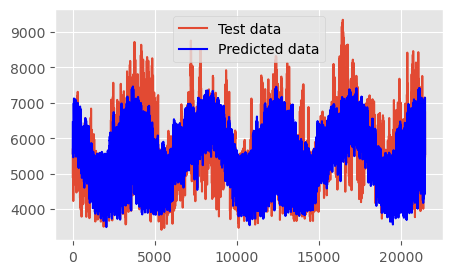

In [703]:
'''plotting the patterns of test and predicted data'''
plt.figure(figsize=(5,3))
plt.plot(original_y_test,label='Test data')
plt.plot(predicted_y_test,color='blue',label='Predicted data')
plt.legend()
plt.show()

In [705]:
'''These are the actual and predicted values of test data'''
labels=np.concatenate((original_y_test,predicted_y_test),axis=1)
print(labels.shape)
labels=pd.DataFrame(labels)
labels=labels.rename(columns={0:'True',1:'Predicted'})
labels

(21481, 2)


,True,Predicted
0,5683.0,6450.655762
1,5393.0,5797.440430
2,5130.0,5663.946289
3,4984.0,5545.028320
4,4917.0,5549.870605
...,...,...
21476,6545.0,6797.813477
21477,6496.0,6675.819336
21478,6325.0,6655.594727
21479,5892.0,5949.951172


#### COMPARSION BETWEEN RESULTS

*PART A* : Create a new data frame where the features are the previous 100 values, and the label is the current value. This can be done using the Pandas shift() function.  
*PART B* :  nstead of using the previous values as features, use the hour, day, day of the week, week of the year information, as well as the periodicity information, along with checking whether the day is a holiday using the holiday module as features to predict the current value using RNN. This can be done by creating a new dataframe with these features and labels.

**When the previous 100 values were used as features,**    
The mean square error loss of given test data is 0.013276323676109314.  
The R2-score of given test data is 0.9874515927427554.  
The mean absolute error loss of given test data is 0.0864560678601265.  
The root mean square error loss of given test data is 0.11522293090820312.  

**When the hour, day, day of week, week of year etc were used as features,**    
The mean square error loss of given test data is 0.4462870955467224.  
The R2-score of given test data is 0.5782734594208421.  
The mean absolute error loss of given test data is 0.5018147230148315.  
The root mean square error loss of given test data is 0.6680472493171692.  

**PART A**  
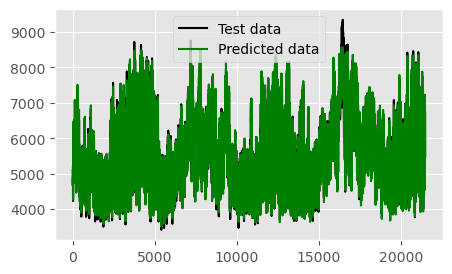

**PART B**  
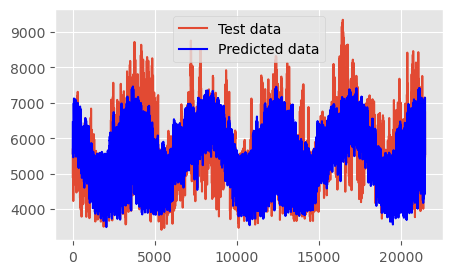

**PART A**  
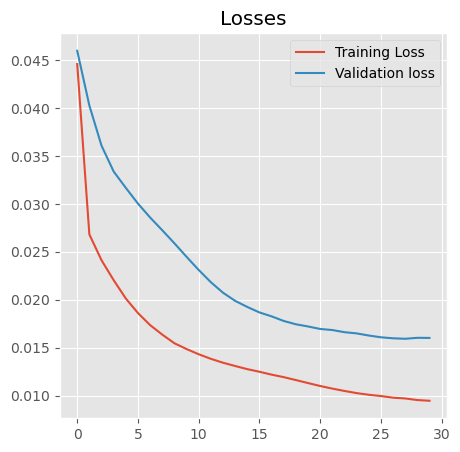

**PART B**  
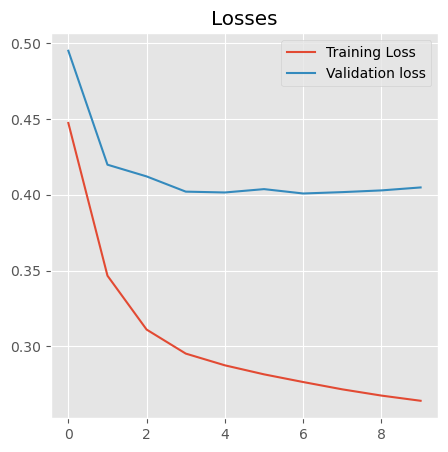

From the above values of the metrics and the graphs, it is clear that the model with the previous 100 values as the features performed better than the one with day,week of hour,periodicity etc as features.Still, the model was able to capture the pattern of the data upto an extend in both cases where the former perofrmed really good with a r2-score of 98.7%.   